# Script to scan the PSSS over a large energy range
### Purpose: To allow the average photon spectrum to be measured over a larger range than the PSSS bandwidth
Contact christopher.arrell@psi.ch

In [17]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
%matplotlib inline
from IPython.display import clear_output, display
import h5py as h5
from scipy.optimize import curve_fit
import seaborn as sns

## Setup and functions setup

In [2]:
PSSS_energy_PV_name = 'SARFE10-PSSS059:ENERGY'
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_cam_x_PV_name = 'SARFE10-PSSS059:MOTOR_X5.VAL'
Energy_from_machine_PV_name = 'SARFE10-PBPG050:ENERGY'

PSSS_energy_PV = ep.PV(PSSS_energy_PV_name)
PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)
PSSS_cam_x_PV = ep.PV(PSSS_cam_x_PV_name)
Energy_from_machine_PV = ep.PV(Energy_from_machine_PV_name)

PSSS_e_axis = PSSS_e_axis_PV.get()

def set_PSSS_energy(energy):
    PSSS_energy_PV.put(energy, wait=True)
    clear_output(wait=True)
    ! python /ioc/modules/qt/PSSS_motion.py -m1 SARFE10-PSSS059
    sleep(10)
    print(energy)
    
def PSSS_energy_scan(Energy_range, NumShots):
        
    Spectrum_scan = []
    e_axis_scan = []
    
    for energy in Energy_range:
        set_PSSS_energy(energy)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_spectrum_PV.add_callback(callback=on_value_change, pv =PSSS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        e_axis_scan.append(PSSS_e_axis_PV.get())
    return(np.array(e_axis_scan),np.array(Spectrum_scan))

def gaus(x,a,x0,sigma,offset):
    return offset +a*np.exp(-(x-x0)**2/(2*sigma**2))

def Spectra_bin(Scan_e_axis, e_axis_full, spectra):
    digi = np.digitize(Scan_e_axis, e_axis_full)   
    Spec_binned = []
    for i in range(0,len(e_axis_full)):
        ind = digi==i+1
        Spec_binned.append(spectra[ind].mean(axis=0))
    return np.asarray(Spec_binned)

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def bimodal(x, H_1, A_1, x0_1, sigma_1,H_2, A_2, x0_2, sigma_2):
    return gauss(x, H_1, A_1, x0_1, sigma_1)+gauss(x, H_2, A_2, x0_2, sigma_2)

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def bimodal_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(bimodal, x, y, p0=[min(y), max(y), mean, sigma,min(y), max(y), mean, sigma])
    return popt

## User inputs - define energy range to scan 

Scan range

In [21]:
E_from = 7850
E_to = 8050
steps = 15
NumShots= 100
Energy_range = np.linspace(E_from, E_to, steps)

Only run the follow cell if you want to save in a single energy position

In [85]:
E_from = 11330
steps = 1
NumShots= 1000
Energy_range = np.linspace(E_from, E_to, steps)

## Scan and take data

In [22]:
set_PSSS_energy(Energy_range[0])
sleep(10)
Scan_e_axis, Scan_spec = PSSS_energy_scan(Energy_range,NumShots)

energy2motor: camArmRot: 47.0059 cristBendRot: 24.5103 camPosX:-23.4746 evPerPix:0.02042
PSSS_motion done.
8050.0


## Bin data

In [23]:
e_axis_full = np.linspace(Scan_e_axis[0,0],Scan_e_axis[-1,-1],7000)

Bin_spec = []
for i in range(0, Scan_e_axis.shape[0]):
    Bin_spec.append(Spectra_bin(Scan_e_axis[i,:], e_axis_full, Scan_spec[i,:].mean(axis=0)))
Bin_spec = np.asarray(Bin_spec)

Spec_range = np.nansum(Bin_spec,axis=0)

/sf/photo/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
/sf/photo/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Save data

In [26]:
! ls /sf/photo

Athos PSCR.ipynb  config    miniconda		 psss		src
bin		  data	    miniconda.sh	 SBST_OPSH_CAM	tmp_data
Checkout	  data.old  pipeline_cam_server  sf_databuffer	two_colour_test


In [27]:
folder = "/sf/photo/psss"
name = 'energy_scan_001.h5'

In [28]:
with h5.File(folder+name, 'w-') as fh:
    fh['Scan_e_axis'] = Scan_e_axis
    fh['Scan_spec'] = Scan_spec
    fh['Energy_range'] = Energy_range
    fh['e_axis_full'] = e_axis_full
    fh['Bin_spec'] = Bin_spec
    fh['Spec_range'] = Spec_range    

## Plot data average

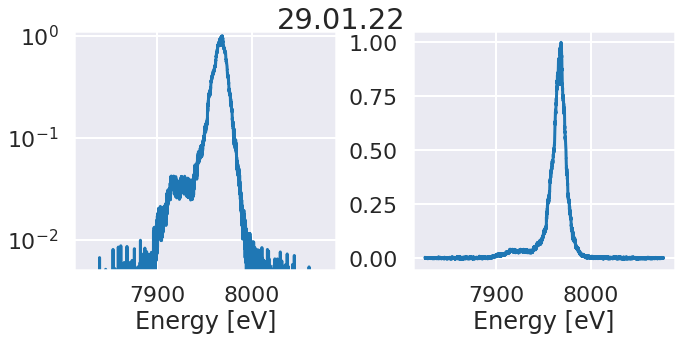

In [36]:
name = "29.01.22"
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=[10,5])
plt.suptitle(name)
plt.subplot(121)
plt.plot(e_axis_full,Spec_range/np.max(Spec_range))
plt.yscale('log')
plt.ylim([0.005,1.1])
plt.xlabel("Energy [eV]")
plt.grid(True)

plt.subplot(122)
plt.plot(e_axis_full,Spec_range/np.max(Spec_range))
plt.xlabel("Energy [eV]")
plt.grid(True)
plt.tight_layout()
plt.savefig('/sf/photo/psss/Aramis_spectral_step')

## Plot single spectra

In [37]:
Scan_spec.shape

(15, 100, 2560)

In [ ]:
Scan_e_axis[i,:], ea_axis_full, Scan_spec[i,:]

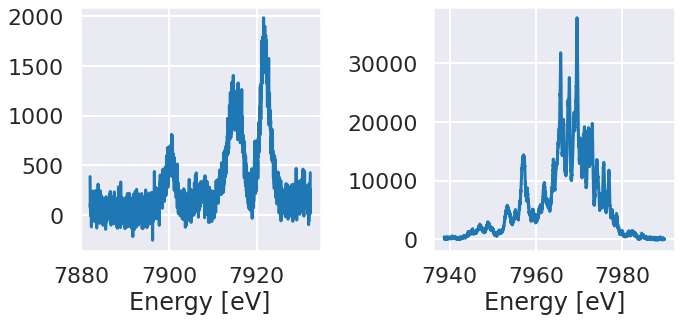

In [50]:
i_1 = 4
i_2 = 8

name = ""
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=[10,5])
plt.suptitle(name)
plt.subplot(121)
plt.plot(Scan_e_axis[i_1,:], Scan_spec[i_1,1,:])
plt.xlabel("Energy [eV]")
plt.grid(True)

plt.subplot(122)
plt.plot(Scan_e_axis[i_2,:], Scan_spec[i_2,2,:])
plt.xlabel("Energy [eV]")
plt.grid(True)
plt.tight_layout()
plt.savefig('/sf/photo/psss/Aramis_spectral_step_single_shot')